In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhanupratapbiswas/inventory-analysis-case-study")

print("Path to dataset files:", path)

c:\Users\Meli_\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Meli_\.cache\kagglehub\datasets\bhanupratapbiswas\inventory-analysis-case-study\versions\1


In [3]:
os.chdir('C:\\Users\\Meli_\\.cache\\kagglehub\\datasets\\bhanupratapbiswas\\inventory-analysis-case-study\\versions\\1')

In [4]:
#Cargar datasets
beg_inv = pd.read_csv('BegInvFINAL12312016.csv')
end_inv = pd.read_csv('EndInvFINAL12312016.csv')
sales = pd.read_csv('SalesFINAL12312016.csv')
purchases = pd.read_csv('PurchasesFINAL12312016.csv')
invoice_purchases = pd.read_csv('InvoicePurchases12312016.csv')
purchase_prices = pd.read_csv('2017PurchasePricesDec.csv')

In [5]:
# Realizar copia del dataset
beg_inv_f = beg_inv.copy() 
end_inv_f = end_inv.copy()
purchases_f = purchases.copy()
invoice_purchases_f= invoice_purchases.copy()
purchase_prices_f = purchase_prices.copy()
sales_f = sales.copy()

In [6]:
# Rellenar datos faltantes en la columna "City" del inventario final
end_inv_f["City"] = end_inv_f["City"].fillna("TYWARDREATH")

# Eliminar filas con valores faltantes en "Size" en la tabla compras
purchases_f.dropna(subset=["Size"], inplace=True)

# Eliminar columna "Approval" de la tabla facturas de compra
invoice_purchases_f = invoice_purchases_f.drop(['Approval'], axis=1)

# Eliminar valores faltantes de las columnas "Description" y "Size" de la tabla precios de compra
purchase_prices_f.dropna(subset=["Description"], inplace=True)
purchase_prices_f.dropna(subset=["Size"], inplace=True)

# Eliminar columna "Volume" de la tabla precios de compra
purchase_prices_f = purchase_prices_f.drop(["Volume"], axis=1)
sales_f = sales_f.drop(["Volume"], axis = 1)

In [7]:
# Calcular el Onhand_Stock
onhand_data = pd.merge(end_inv, sales, on='InventoryId', how='left')
onhand_data['Onhand_Stock'] = onhand_data['onHand'] - onhand_data['SalesQuantity']

# Agregar información de marca y descripción
onhand_data = pd.merge(onhand_data, beg_inv[['InventoryId', 'Brand', 'Description']], on='InventoryId', how='left')

# Calcular el Optimal_SS
onhand_data['Optimal_SS'] = ((onhand_data['onHand'] + beg_inv.set_index('InventoryId').get(onhand_data['InventoryId'], default=0)) / 2) * 0.5

# Determinar el estado del inventario
def inventory_status(row):
    if row['Onhand_Stock'] >= row['Optimal_SS']:
        return 'OK'
    if row['Onhand_Stock'] < row['Optimal_SS'] * 0.5:
        return 'BAJO'
    return 'EXCESIVO'

onhand_data['Inventory_Status'] = onhand_data.apply(inventory_status, axis=1)

# Filtrar las columnas necesarias
onhand_inv_data = onhand_data[['Brand', 'Description', 'Onhand_Stock', 'Optimal_SS', 'Inventory_Status']]

# Mostrar el DataFrame resultante
print(onhand_inv_data)

# Exportar a CSV si es necesario
onhand_inv_data.to_csv('OnhandInventoryData.csv', index=False)

         Brand                  Description  Onhand_Stock  Optimal_SS  \
0         58.0  Gekkeikan Black & Gold Sake          10.0        2.75   
1         58.0  Gekkeikan Black & Gold Sake           9.0        2.75   
2         58.0  Gekkeikan Black & Gold Sake          10.0        2.75   
3         58.0  Gekkeikan Black & Gold Sake          10.0        2.75   
4         58.0  Gekkeikan Black & Gold Sake          10.0        2.75   
...        ...                          ...           ...         ...   
1029144    NaN                          NaN           NaN        0.75   
1029145    NaN                          NaN           NaN        0.75   
1029146    NaN                          NaN           NaN        0.75   
1029147    NaN                          NaN           NaN        0.75   
1029148    NaN                          NaN           NaN        0.50   

        Inventory_Status  
0                     OK  
1                     OK  
2                     OK  
3              

In [8]:
# Filtrar los productos críticos con estado "BAJO"
critical_products = onhand_inv_data[onhand_inv_data['Inventory_Status'] == 'BAJO']

# Ordenar los productos por el nivel de stock (Onhand_Stock) en orden ascendente
critical_products = critical_products.sort_values(by='Onhand_Stock', ascending=True)

# Seleccionar los 10 productos más críticos
top_critical_products = critical_products.head(10)

# Mostrar los resultados
print(top_critical_products)

# Exportar a CSV si es necesario
top_critical_products.to_csv('TopCriticalProducts.csv', index=False)

          Brand                   Description  Onhand_Stock  Optimal_SS  \
233932   8576.0               E & J Brandy VS        -391.0       10.25   
233352   8441.0           Baileys Irish Cream        -340.0        5.25   
426186  32831.0  Carpineto Dogajolo Tuscan Rd        -278.0        7.00   
246681  42188.0  Moet & Chandon Nectar Imp Rs        -247.0        1.50   
758157      NaN                           NaN        -227.0        3.25   
213983   1001.0           Baileys 50mL 4 Pack        -182.0        0.25   
470974  13215.0     Moet Nectar Imperial Rose        -168.0        3.00   
218144   3025.0        Ciroc Snap Frost Vodka        -152.0        7.00   
738136    807.0                      Jim Beam        -147.0        2.50   
18597    8312.0           Bols Curacao Orange        -138.0       10.50   

       Inventory_Status  
233932             BAJO  
233352             BAJO  
426186             BAJO  
246681             BAJO  
758157             BAJO  
213983            

C:\Users\Meli_\AppData\Local\Temp\ipykernel_57912\2750003596.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


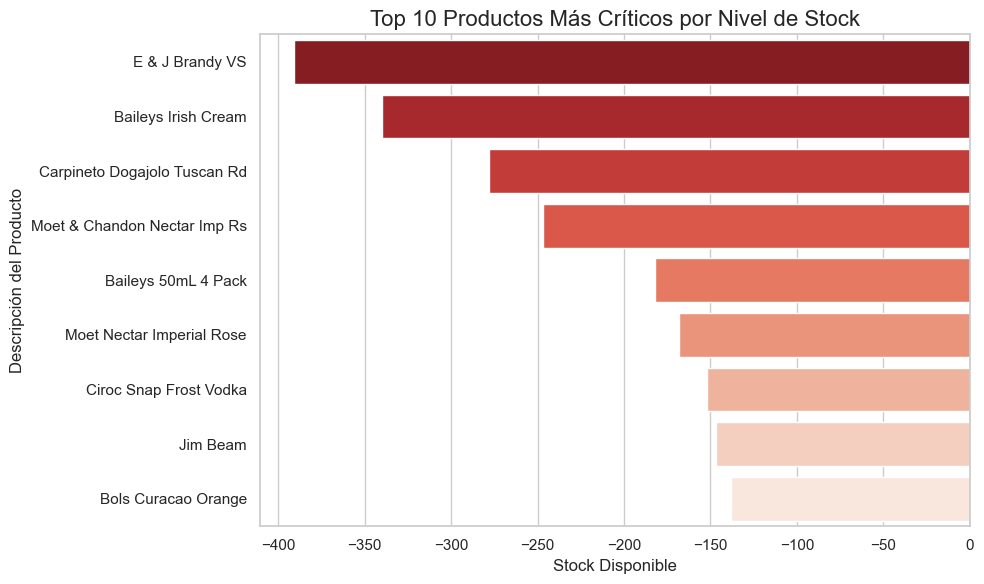

In [12]:
# Configuración de estilo para Seaborn (opcional)
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Onhand_Stock', 
    y='Description',
    data=top_critical_products, 
    palette="Reds_r"
)

# Añadir etiquetas y título
plt.title("Top 10 Productos Más Críticos por Nivel de Stock", fontsize=16)
plt.xlabel("Stock Disponible", fontsize=12)
plt.ylabel("Descripción del Producto", fontsize=12)

# Ajustar el diseño para evitar recortes
plt.tight_layout()

# Mostrar el gráfico
plt.show()